In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from tldextract import extract
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [3]:
data = pd.read_csv("data/train_data.csv", sep=';')

In [4]:
data.head()

,COOKIE_ID,LOCAL_TIME,PAGE_NAME,H2549
0,0,2018-02-28 16:24:05.570,http://www.01net.com/actualites/pourquoi-la-no...,1
1,1,2018-02-17 18:17:16.310,http://www.01net.com/search,0
2,2,2018-02-09 22:49:13.500,http://www.01net.com/telecharger/windows/Multi...,0
3,3,2018-02-11 14:15:36.478,http://www.01net.com/telecharger/,0
4,4,2018-02-26 09:41:26.059,http://www.01net.com/tests/huawei-p8-lite-2017...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341411 entries, 0 to 341410
Data columns (total 4 columns):
COOKIE_ID     341411 non-null int64
LOCAL_TIME    341411 non-null object
PAGE_NAME     341411 non-null object
H2549         341411 non-null int64
dtypes: int64(2), object(2)
memory usage: 10.4+ MB


In [6]:
data.nunique()

COOKIE_ID       8577
LOCAL_TIME    341294
PAGE_NAME     117054
H2549              2
dtype: int64

In [7]:
def url_handler(row):
    # Dfine the parsers
    urllib_parser = urlparse(row)
    tld_parser = extract(row)
    
    # Set up the new row
    row = [urllib_parser.scheme, tld_parser.subdomain, tld_parser.domain] + urllib_parser.path.rsplit('/',1)
    
    return row

In [8]:
new_data = pd.DataFrame(data.PAGE_NAME.apply(url_handler).tolist(), columns=["Protocole", "SubDomain", "Domain", "Directory", "Page"])
new_data = pd.concat([data, new_data], axis=1)

In [9]:
new_data.head()

,COOKIE_ID,LOCAL_TIME,PAGE_NAME,H2549,Protocole,SubDomain,Domain,Directory,Page
0,0,2018-02-28 16:24:05.570,http://www.01net.com/actualites/pourquoi-la-no...,1,http,www,01net,/actualites,pourquoi-la-nouvelle-interface-de-snapchat-est...
1,1,2018-02-17 18:17:16.310,http://www.01net.com/search,0,http,www,01net,,search
2,2,2018-02-09 22:49:13.500,http://www.01net.com/telecharger/windows/Multi...,0,http,www,01net,/telecharger/windows/Multimedia/lecteurs_video...,23823.html
3,3,2018-02-11 14:15:36.478,http://www.01net.com/telecharger/,0,http,www,01net,/telecharger,
4,4,2018-02-26 09:41:26.059,http://www.01net.com/tests/huawei-p8-lite-2017...,0,http,www,01net,/tests,huawei-p8-lite-2017-fiche-technique-36545.html


In [10]:
new_data.Domain.value_counts().head()

lequipe       24002
boursorama    23087
lefigaro      16822
lemonde       16551
20minutes     11462
Name: Domain, dtype: int64

In [11]:
#pd.pivot_table(new_data[['COOKIE_ID', 'Domain']], index='COOKIE_ID', columns='Domain')

In [12]:
to_pivot_data = new_data[['COOKIE_ID', 'Domain', 'H2549']].groupby(["COOKIE_ID", pd.Grouper("Domain")]).count().reset_index()

In [13]:
to_pivot_data = pd.pivot_table(to_pivot_data, index='COOKIE_ID', columns='Domain').fillna(0)

In [14]:
to_pivot_data.columns = to_pivot_data.columns.droplevel(level=0)

In [39]:
to_pivot_data.sample(5, random_state=18)

Domain,01net,13emerue,20minutes,6play,7magazine,admagazine,ados,agate-france,agoravox,aisnenouvelle,...,varmatin,viepratique,virginradio,vogue,voici,vsd,weo,xboxygen,zdnet,zone-turf
COOKIE_ID,,,,,,,,,,,,,,,,,,,,,
1819,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1446,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,13.0
8354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
cols = ['01net', '13emerue', 'doctissimo', 'virginradio', 'zdnet', 'zone-turf']

In [48]:
#to_pivot_data[to_pivot_data['13emerue']>0][cols].head(7).to_excel('url_features.xlsx')

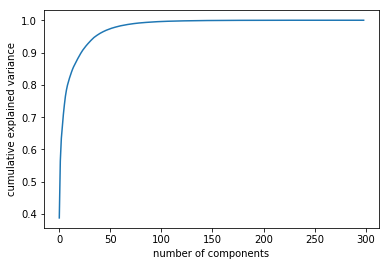

In [54]:
pca = PCA().fit(to_pivot_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

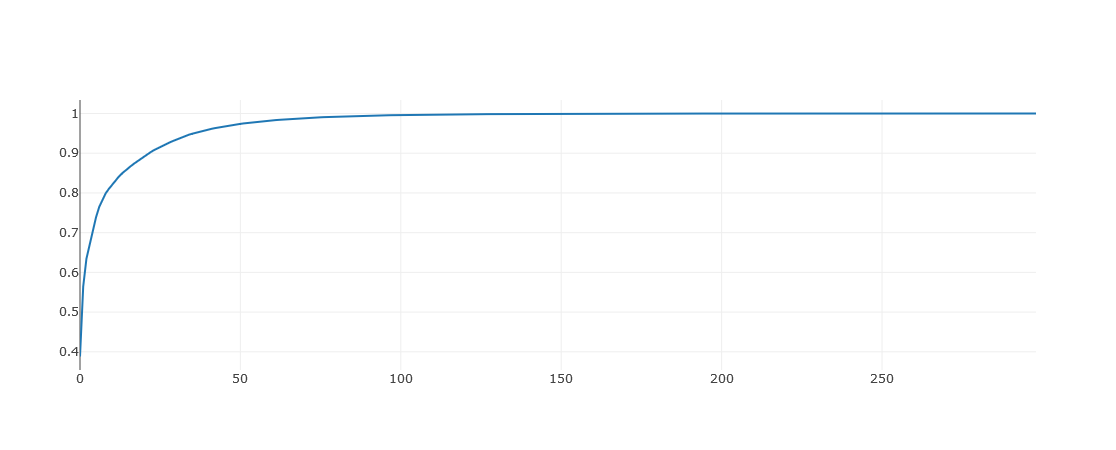

In [58]:
# Create a trace
trace = go.Scatter(
    y = np.cumsum(pca.explained_variance_ratio_)
)

iplot([trace])

# Parte consacrée au datetimeµ

In [15]:
data.head()

,COOKIE_ID,LOCAL_TIME,PAGE_NAME,H2549
0,0,2018-02-28 16:24:05.570,http://www.01net.com/actualites/pourquoi-la-no...,1
1,1,2018-02-17 18:17:16.310,http://www.01net.com/search,0
2,2,2018-02-09 22:49:13.500,http://www.01net.com/telecharger/windows/Multi...,0
3,3,2018-02-11 14:15:36.478,http://www.01net.com/telecharger/,0
4,4,2018-02-26 09:41:26.059,http://www.01net.com/tests/huawei-p8-lite-2017...,0


In [16]:
data.LOCAL_TIME = pd.to_datetime(data.LOCAL_TIME)

In [17]:
data['hour'] = data.LOCAL_TIME.dt.hour

In [18]:
data_to_stack = data[['COOKIE_ID', 'hour', 'H2549']].groupby(["COOKIE_ID", pd.Grouper("hour")]).count().reset_index()

In [19]:
data_to_stack = pd.pivot_table(data_to_stack, index='COOKIE_ID', columns='hour', values="H2549").fillna(0)
data_to_train = data_to_stack.copy()

In [20]:
data_to_stack = (100*data_to_stack/data_to_stack.sum(axis=0))

In [21]:
data_to_stack.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
COOKIE_ID,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004644,...,0.056774,0.014661,0.022716,0.015504,0.003687,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.009289,...,0.036129,0.009774,0.036345,0.058140,0.162230,0.021998,0.321667,0.040367,0.021664,0.000000
2,0.240336,0.0,0.0,0.0,0.785634,0.855615,1.006036,0.838091,0.085023,0.102174,...,0.196129,0.200371,0.077234,0.189922,0.117985,0.197985,0.124826,0.040367,0.108319,0.293166
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025806,0.048871,0.009086,0.019380,0.014748,0.017599,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.050302,0.012146,0.039241,0.018577,...,0.000000,0.014661,0.009086,0.003876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
#pd.DataFrame(data_to_stack.to_records())

In [26]:
users_0 = data[data.H2549 == 0]
users_1 = data[data.H2549 == 1]

In [27]:
users_0 = users_0.groupby(["COOKIE_ID","hour"]).agg('count').reset_index().drop(["LOCAL_TIME", "PAGE_NAME"], axis=1).rename(columns={"H2549":"Nb_Conn"})
users_1 = users_1.groupby(["COOKIE_ID","hour"]).agg('count').reset_index().drop(["LOCAL_TIME", "PAGE_NAME"], axis=1).rename(columns={"H2549":"Nb_Conn"})

In [28]:
trace0 = go.Bar( 
    x=users_0.hour,
    y=users_0.Nb_Conn,
    name='Users 0'
)
trace1 = go.Bar( 
    x=users_1.hour,
    y=users_1.Nb_Conn,
    name='Users 1'
)

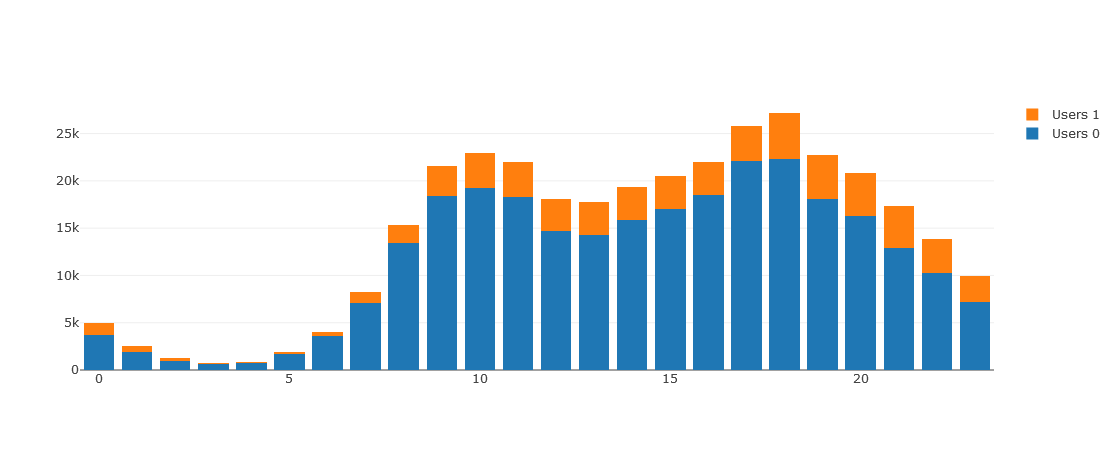

In [29]:
donnees = [trace0, trace1]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=donnees, layout=layout)
iplot(fig, filename='stacked-bar')

# PArtie modélisation

In [31]:
y_df = data.groupby("COOKIE_ID").agg('mean')["H2549"].astype(int).to_frame()

In [32]:
data_to_train = data_to_train.merge(y_df, on="COOKIE_ID")

In [33]:
data_to_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,H2549
COOKIE_ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,2.0,8.0,15.0,44.0,5.0,67.0,7.0,3.0,0.0,0
2,12.0,0.0,0.0,0.0,7.0,16.0,40.0,69.0,13.0,22.0,...,41.0,17.0,49.0,32.0,45.0,26.0,7.0,15.0,29.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,2.0,5.0,4.0,4.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,4.0,...,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [38]:
y = data_to_train.H2549
X = data_to_train.drop("H2549", axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
clf = svm.SVC(gamma='scale', C=10000)
clf

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    #model = clf.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

TRAIN: 7719 TEST: 858
TRAIN: 7719 TEST: 858
TRAIN: 7719 TEST: 858
TRAIN: 7719 TEST: 858
TRAIN: 7719 TEST: 858
TRAIN: 7719 TEST: 858
TRAIN: 7719 TEST: 858
TRAIN: 7720 TEST: 857
TRAIN: 7720 TEST: 857
TRAIN: 7720 TEST: 857


In [ ]:
clf = svm.SVC(gamma='scale', C=10**5, class_weight='balanced', kernel='linear')
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("score : ", precision_recall_fscore_support(y_true=y_test, y_pred=y_pred)[2][1])

In [ ]:
kf = KFold(n_splits=10)
nb_step = 0
for train_index, test_index in kf.split(X):
    nb_step = nb_step+1
    clf = svm.SVC(gamma='scale', C=1, class_weight='balanced', kernel='linear')
    model = clf.fit(X.iloc[train_index,], y[train_index])
    y_pred = model.predict(X.iloc[test_index,])
    print ("####  NB Step = ", nb_step, "############")
    print("score : ", precision_recall_fscore_support(y_true=y[test_index], y_pred=y_pred)[2][1])
    scores2 += precision_recall_fscore_support(y_true=y[test_index], y_pred=y_pred)[2][1]
print("Score moyen : ", np.mean(scores2))

In [36]:
scores=[]
for c in range(10**0, 10**5+2, 10**4):
    clf = svm.SVC(gamma='scale', C=c)
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print ("####  C = ", c, "############")
    print("score : ", precision_recall_fscore_support(y_true=y_test, y_pred=y_pred)[2][1])
    scores += precision_recall_fscore_support(y_true=y_test, y_pred=y_pred)[2][1]

####  C =  1 ############
score :  0.0


C:\Users\Bouba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



####  C =  10001 ############
score :  0.1366223908918406
####  C =  20001 ############
score :  0.148014440433213
####  C =  30001 ############
score :  0.15189873417721517
####  C =  40001 ############
score :  0.15798922800718132
####  C =  50001 ############
score :  0.16254416961130744
####  C =  60001 ############
score :  0.16283185840707964
####  C =  70001 ############
score :  0.16225749559082894
####  C =  80001 ############
score :  0.16376306620209058
####  C =  90001 ############
score :  0.1721170395869191
####  C =  100001 ############
score :  0.1818181818181818


In [182]:
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [189]:
precision_recall_fscore_support(y_true=y_test, y_pred=y_pred)[2][1]

0.11642411642411642

In [184]:
pd.Series(y_pred).value_counts()

0    1594
1     122
dtype: int64

In [186]:
confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[1263,   94],
       [ 331,   28]], dtype=int64)